In [1]:
import numpy as np
from STMiner import SPFinder

sp = SPFinder()
# sp.read_h5ad(file='I://zebrafish/10X_Visium_hunter2021spatially_sample_C_data.h5ad')
# sp.read_h5ad(file='F://空间转录组数据/MOUSE/V1_Adult_Mouse_Brain_filtered_feature_bc_matrix.h5',bin_size=50)
sp.read_h5ad(file='G://5DPI_2.h5ad', bin_size=50)

In [ ]:
import pandas as pd

df = pd.DataFrame(sp.adata.X.todense())
df.index = sp.adata.obs['x'].astype(str) + 'x' + sp.adata.obs['y'].astype(str)
df.columns = sp.adata.var.index
df.T.to_csv('count.csv')

In [ ]:
sp.flush_app()
sp.app.run()

In [ ]:
sp.load_marked_image('')

In [ ]:
# gene_list=list(sp.adata.var.nlargest(700, 'dispersions_norm').index)
gene_list=list(sp.adata.var.index)
sp.build_distance_array(method='cs', gene_list=gene_list)

In [25]:
sp.fit_pattern(n_comp=20, min_cells=200, n_top_genes=500, remove_low_exp_spots=False)

Fitting GMM...: 100%|██████████| 500/500 [01:16<00:00,  6.53it/s]


In [26]:
sp.build_distance_array()

Building distance array...: 100%|██████████| 500/500 [05:01<00:00,  1.66it/s]


In [ ]:
import pickle
with open('da_dip5_2_h200_t100.pkl', 'wb') as file:
    pickle.dump(sp.genes_distance_array, file)

In [ ]:
import pickle
with open('da.pkl', 'rb') as file:
    sp.genes_distance_array = pickle.load(file)
sp.cluster_gene(n_clusters=6, mds_components=20, use_highly_variable_gene=False, n_top_genes=800)

In [34]:
sp.cluster_gene(n_clusters=5, mds_components=20, use_highly_variable_gene=False, n_top_genes=500)

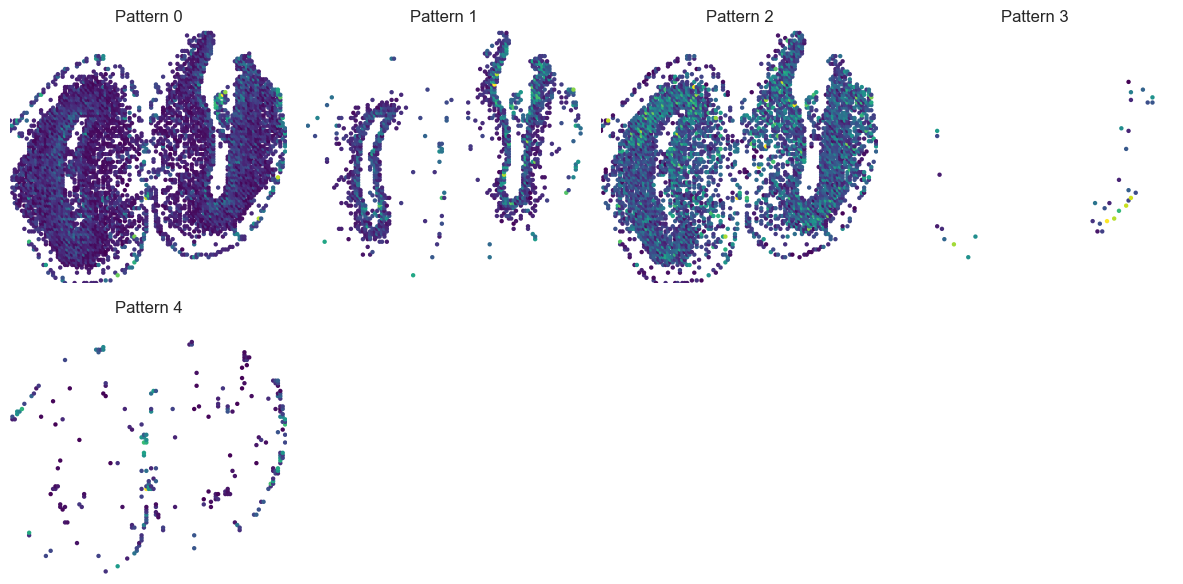

In [35]:
sp.get_pattern_array(vote_rate=0.25)
sp.plot.plot_pattern(vmax=95,
                     heatmap=False,
                     s=10,
                     reverse_y=False,
                     reverse_x=True,
                     # image_path='E://OneDrive - stu.xjtu.edu.cn/paper/cut_img.png',
                     rotate_img=False, 
                     k=3,
                     aspect=0.55,                    
                     output_path=None
                     )

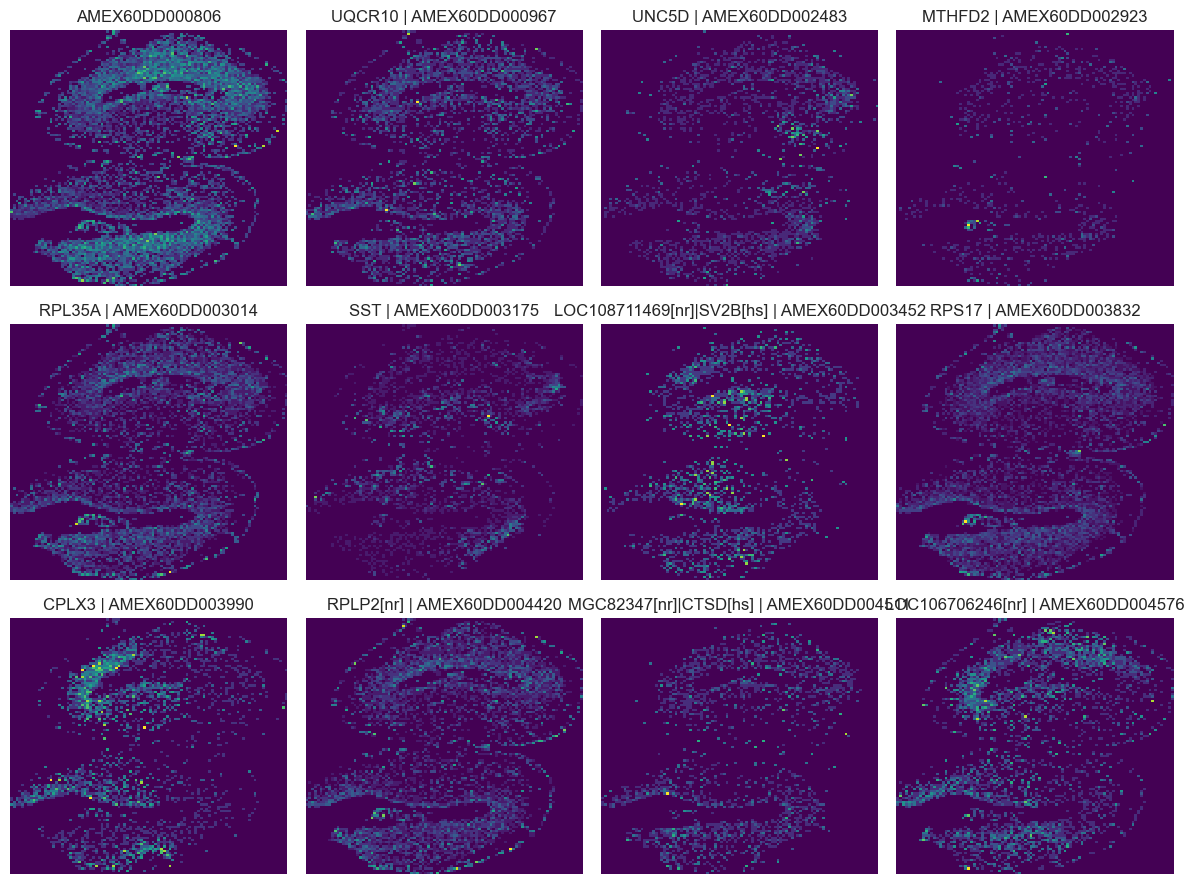

In [33]:
sp.plot.plot_genes(label=0)

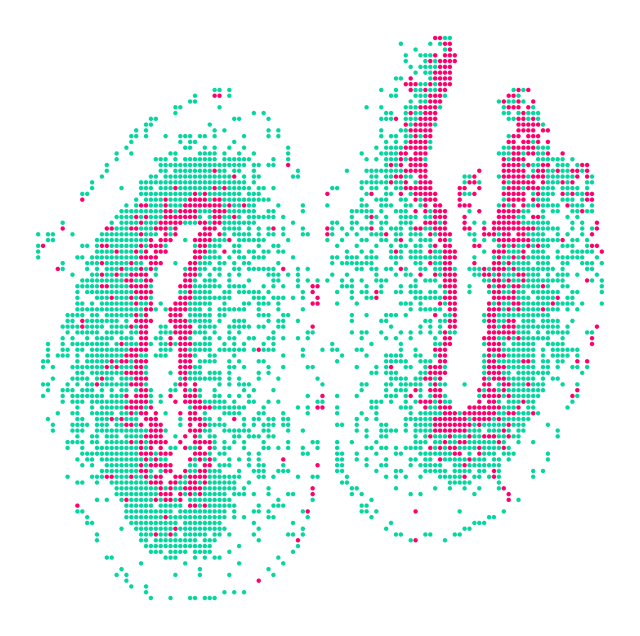

In [36]:
sp.plot.plot_intersection(pattern_list=[1,2],reverse_x=True,reverse_y=False, figsize=(8,8))

(-5.75, 120.75, -4.8500000000000005, 101.85)

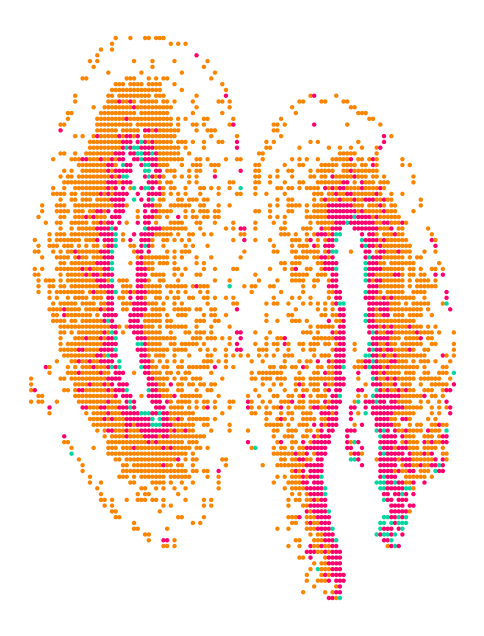

In [43]:
import os
import seaborn as sns
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def _adjust_arr(arr, rotate, reverse_x, reverse_y):
    if rotate:
        arr = np.rot90(arr)
    if reverse_y:
        arr = np.flipud(arr)
    if reverse_x:
        arr = np.fliplr(arr)
    return arr


pattern_list = [1, 2]
sum_array = np.zeros(sp.patterns_binary_matrix_dict[pattern_list[0]].shape)
flag = 1
for i in pattern_list:
    sum_array += np.where(sp.patterns_binary_matrix_dict[i] > 0, flag, 0)
    flag += 1
sum_array = _adjust_arr(sum_array, rotate=False, reverse_x=False, reverse_y=False)
sparse_matrix = csr_matrix(sum_array)

# image_path = 'E://OneDrive - stu.xjtu.edu.cn/paper/cut_img.png'

plt.figure(figsize=(6, 8))
# bg_img = mpimg.imread(image_path)
from matplotlib.colors import ListedColormap
# plt.imshow(bg_img, extent=[0, sum_array.shape[0], 0, sum_array.shape[1]], aspect=0.55)
sns.set_style('white')
sns.scatterplot(x=sparse_matrix.nonzero()[0],
                y=sparse_matrix.nonzero()[1],
                c=sparse_matrix.data,
                cmap=ListedColormap(['#06d6a0', '#fb8500', '#ff006e']),
                s=10,
                edgecolor='none')
plt.axis('off')
# plt.savefig(os.path.join('./', "scatterplot_mx.eps"), dpi=1000, format='eps')

In [ ]:
sp.plot.count_array

In [ ]:
sp.plot.plot_genes(label=3, vmax=95, plot_type='scatter', s=10, rotate=True)

In [ ]:
sp.plot.plot_tsne()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.Graph()

for i, center_i in enumerate(sp.kmeans_fit_result.cluster_centers_):
    graph.add_node(i)
    for j, center_j in enumerate(sp.kmeans_fit_result.cluster_centers_):
        if not graph.has_node(j):
            graph.add_node(j)
        if not graph.has_edge(i, j) and i != j:
            graph.add_edge(i, j, weight=np.linalg.norm(center_i - center_j))

pos = nx.spring_layout(graph, weight='weight')  # 布局算法，这里使用了Spring布局
nx.draw(graph, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_color='black',
        font_weight='bold')
edge_labels = nx.get_edge_attributes(graph, 'weight')
rounded_dict = {}
for key, value in edge_labels.items():
    rounded_value = round(1 / value, )  # 使用round函数保留三位小数
    rounded_dict[key] = rounded_value
nx.draw_networkx_edge_labels(graph, pos, edge_labels=rounded_dict)
plt.title("Network Visualization")
plt.show()


In [ ]:
from STMiner.node2vec import Node2Vec
import networkx as nx
import matplotlib.pyplot as plt

import networkx as nx
import matplotlib.pyplot as plt

graph = nx.Graph()

for i, center_i in enumerate(sp.kmeans_fit_result.cluster_centers_):
    graph.add_node(i)
    for j, center_j in enumerate(sp.kmeans_fit_result.cluster_centers_):
        if not graph.has_node(j):
            graph.add_node(j)
        if not graph.has_edge(i, j) and i != j:
            graph.add_edge(i, j, weight=np.linalg.norm(center_i - center_j))
            
            
graph2 = nx.Graph()

for i, center_i in enumerate(a):
    graph2.add_node(i)
    for j, center_j in enumerate(a):
        if not graph2.has_node(j):
            graph2.add_node(j)
        if not graph2.has_edge(i, j) and i != j:
            graph2.add_edge(i, j, weight=np.linalg.norm(center_i - center_j))

node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, p=1, q=2)
node2vec2 = Node2Vec(graph2, dimensions=64, walk_length=30, num_walks=200, p=1, q=2)
# 训练模型
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = model.wv
arr = node_embeddings.vectors


model2 = node2vec2.fit(window=10, min_count=1, batch_words=4)
node_embeddings2 = model2.wv
arr2 = node_embeddings2.vectors

In [ ]:
import numpy as np
result = np.vstack((arr, arr2))
from sklearn.cluster import KMeans

fit_result = KMeans(n_clusters=6, random_state=0, max_iter=1000, n_init=20).fit(result)
fit_result.labels_

In [ ]:
sp.adata.var.index[0]

In [ ]:
arr2

In [ ]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

with open('df.pkl', 'rb') as file:
    df = pickle.load(file)
sns.relplot(df, x='x', y='y', style='label', s=20)

In [ ]:
import seaborn as sns
sns.mpl_palette("viridis", as_cmap=True)

In [ ]:
sns.clustermap(sp.genes_distance_array)

In [ ]:
sp.plot.plot_tsne(method='umap')

In [ ]:
print("原本--------------------------------")
# CS: offset:10; under:0.1; p:0.8
print(656 / 700 * 100)
# MSE: offset:10; under:0.1; p:0.8
print(121 / 700 * 100)
# GMM: offset:10; under:0.1; p:0.8
print(700 / 700 * 100)

print("周期--------------------------------")
# CS: offset:10; under:0.1; p:0.8
print(572 / 700 * 100)
# MSE: offset:10; under:0.1; p:0.8
print(112 / 700 * 100)
# GMM: offset:10; under:0.1; p:0.8
print(700 / 700 * 100)

print("欠采样--------------------------------")
# CS: offset:10; under:0.1; p:0.8
print(639 / 700 * 100)
# MSE: offset:10; under:0.1; p:0.8
print(111 / 700 * 100)
# GMM: offset:10; under:0.1; p:0.8
print(700 / 700 * 100)

print("欠采样--------------------------------")
# CS: offset:10; under:0.1; p:0.8
print(568 / 700 * 100)
# MSE: offset:10; under:0.1; p:0.8
print(201 / 700 * 100)
# GMM: offset:10; under:0.1; p:0.8
print(676 / 700 * 100)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
categories = ['Zebrafish', 'Category B', 'Category C']
data1 = [100, 100, 100]
data2 = [93.71, 81.74, 91.29]
data3 = [17.29, 16, 15.86]
data4 = [14.29, 14.29, 14.29]

x = np.arange(len(categories))  # x轴坐标位置
width = 0.1  # 每个柱子的宽度

# 创建一个子图
fig, ax = plt.subplots()

# 绘制三个数据
ax.bar(x - width, data1, width, label='STMiner')
ax.bar(x, data2, width, label='SC')
ax.bar(x + width, data3, width, label='MSE')
ax.bar(x + width*2, data4, width, label='Random')

# 添加标签、标题和图例
ax.set_xlabel('Categories')
ax.set_ylabel('Values')
ax.set_title('Bar Chart with Three Sets of Data')
ax.set_xticks(x)
ax.set_xticklabels(categories)
plt.axhline(y=100, color='red', linestyle='--', label="y=100")

# 显示图形
# plt.legend()
plt.show()


In [ ]:
import pandas as pd

df = pd.DataFrame([['Raw', 100, 'STMiner'],
                   ['Periodicity', 100, 'STMiner'],
                   ['Undersampling', 100, 'STMiner'],
                   ['Gauss', 96.57, 'STMiner'],
                   ['Raw', 17.29, 'MSE'],
                   ['Periodicity', 16, 'MSE'],
                   ['Undersampling', 15.86, 'MSE'],
                   ['Gauss', 28.71, 'MSE'],
                   ['Raw', 93.71, 'Cosine similarity'],
                   ['Periodicity', 81.74, 'Cosine similarity'],
                   ['Undersampling', 91.29, 'Cosine similarity'],
                   ['Gauss', 81.14, 'Cosine similarity'],
                   ['Raw', 14.29, 'Random'],
                   ['Periodicity', 14.29, 'Random'],
                   ['Undersampling', 14.29, 'Random'],
                   ['Gauss', 14.29, 'Random']],
                  columns=['type', 'accuracy', 'method'])
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] =42
mpl.rcParams['font.family'] = 'Arial'
sns.set_style("white")
sns.barplot(df,
            x='type',
            y='accuracy',
            hue='method',
            order=['Raw', 'Undersampling', 'Periodicity', 'Gauss'],
            hue_order=['STMiner', 'Cosine similarity', 'MSE', 'Random'],
            palette=['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2'])
plt.ylabel(None)
plt.xlabel(None)
plt.yticks(fontsize=15)
plt.xticks(fontsize=14)
plt.title('Accuracy',fontsize=17)
plt.savefig('Accuracy.eps',dpi=1000,format='eps')

In [ ]:
sp.genes_labels[sp.genes_labels['gene_id']=='BRAFhuman']

In [ ]:
sp.adata.var.loc['BRAFhuman']

In [ ]:
sp.plot.plot_pattern_1(vmax=99,
                     vote_rate=0.25,
                     heatmap=False,
                     s=10,
                     reverse_y=True,
                     reverse_x=True,
                     image_path='E://OneDrive - stu.xjtu.edu.cn/paper/cut_img.png',
                     rotate_img=True, 
                     k=4)

In [ ]:

with open('df.pkl', 'rb') as file:
    df = pickle.load(file)
df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

m = sns.relplot(df, x='x', y='y', col='label', col_wrap=4,cmap='viridis',palette='viridis',hue='c',hue_norm=plt.Normalize(0, 60))

for ax in m.axes:
    ax.axis('off')
    bg_img = mpimg.imread('E://OneDrive - stu.xjtu.edu.cn/paper/cut_img.png')
    bg_img = np.rot90(bg_img, k=4)
    ax.imshow(bg_img, extent=[0, df['x'].max(), 0, df['y'].max()], aspect=0.54)
plt.show()

In [ ]:
sp.plot.plot_genes(label=4, vmax=100, n_gene=20)

In [ ]:
sp.adata=adata

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
sp.plot.plot_gene('gene_P1_N', reverse_x=True, rotate=True)

In [ ]:
sp.genes_labels

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(sp.mds_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=sp.kmeans_fit_result.labels_, cmap='tab10')
plt.title("t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label='Labels')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.savefig('tsne.eps', dpi=1000, format='eps')
plt.show()

In [ ]:
import umap
import matplotlib.pyplot as plt
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
embedded_data = umap_model.fit_transform(sp.mds_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=sp.kmeans_fit_result.labels_,cmap='tab10')
plt.title("UMAP")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label='Labels')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
df = sp.compare_gene_to_genes('BRAFhuman')

In [ ]:
x_min = sp.adata.obsm['spatial_real'][:,1].min()
x_max = sp.adata.obsm['spatial_real'][:,1].max()
y_min = sp.adata.obsm['spatial_real'][:,0].min()
y_max = sp.adata.obsm['spatial_real'][:,0].max()
print(x_min, x_max, y_min,y_max)
print((y_max-y_min)/(x_max-x_min))

In [ ]:
from STMiner.Algorithm.distance import get_exp_array
from sklearn import mixture
from STMiner.Algorithm.distribution import array_to_list


def get_gmm(matrix, n_comp=10):
    arr = np.array(matrix, dtype=np.int32)
    result = array_to_list(arr)
    gmm = mixture.GaussianMixture(n_components=n_comp, max_iter=200).fit(result)
    return gmm


image = io.imread("E:/data/RegionC/RegionCplaqueHires.png")
cropped_image = cut_image(image)
resized = transform.resize(cropped_image, get_exp_array(adata, adata.var.index[0]).shape)
gaussian = filters.gaussian(resized, 3)
binary = np.where(gaussian > np.percentile(gaussian, 40), 1, 0)
gmm = get_gmm(binary, n_comp=20)

In [ ]:
x_min = sp.adata.obsm['spatial_real'][:,1].min()
x_max = sp.adata.obsm['spatial_real'][:,1].max()
y_min = sp.adata.obsm['spatial_real'][:,0].min()
y_max = sp.adata.obsm['spatial_real'][:,0].max()
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
# 打开图像文件
image = Image.open("E://human/GSM4838132_Visium_B_image.tif/GSM4838132_Visium_B_image.tif")  # 替换为你的图像文件路径

# 使用crop方法进行剪裁
cropped_image = image.crop((x_min, y_min, x_max, y_max))

# 保存剪裁后的图像
cropped_image.save("cropped_image.tif")  # 保存为新的文件，也可以覆盖原始文件

In [ ]:
sp.fit_pattern(n_top_genes=500, n_comp=50, min_cells=200)
sp.build_distance_array()

In [ ]:
sp.cluster_gene(n_clusters=7, mds_components=20)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
index = pd.DataFrame([db,si,ch], index=['1/db','si','ch']).T
index_1 = (index-index.min()) / (index.max() - index.min())
sns.lineplot(index_1, markers=True)
plt.xticks(list(range(2, 12, 1)))
plt.xlabel("Number of Clusters")
plt.ylabel("Normalized Score")
plt.title("Evaluate Clustering Performance")
plt.show()

In [ ]:
sp.genes_distance_array.loc['frzb'].mean()

In [ ]:
df = pd.DataFrame(sp.genes_distance_array.mean(axis=1), columns=['mean'])
df = df.sort_values(by='mean', ascending=False)

In [ ]:
import seaborn as sns
sns.histplot(df)

In [ ]:
sp.genes_distance_array.loc['pax3a'].mean()

In [ ]:
from STMiner.Algorithm.distance import get_exp_array
from scipy.sparse import csr_matrix
import seaborn as sns

arr = get_exp_array(sp.adata, 'myl10')
arr = np.maximum(arr - np.mean(arr[arr != 0]), 0)
sparse_matrix = csr_matrix(arr)
sns.scatterplot(x=sparse_matrix.nonzero()[1],
                y=sparse_matrix.nonzero()[0],
                c=sparse_matrix.data
                )


In [ ]:
from matplotlib.transforms import Bbox
import matplotlib.pyplot as plt

# 创建一个2x2的子图网格
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# 绘制在所有子图中
axs[0, 0].plot([1, 2, 3, 4], [1, 2, 3, 4])
axs[0, 0].set_title('ss')

axs[0, 1].scatter([1, 2, 3, 4], [4, 3, 2, 1])
axs[0, 1].set_title('dd')

axs[1, 0].bar(['A', 'B', 'C', 'D'], [10, 20, 5, 15])
axs[1, 0].set_title('bb')

axs[1, 1].pie([30, 20, 25, 15], labels=['X', 'Y', 'Z', 'W'], autopct='%1.1f%%')
axs[1, 1].set_title('aa')

# 获取特定子图的位置
subplotspec = axs[0, 1].get_subplotspec()

# 使用subplotspec来创建新的坐标轴
new_ax = fig.add_axes(subplotspec.get_position(fig), frameon=False)

# 设置新坐标轴的内容
new_ax.plot([0, 1, 2, 3], [3, 4, 2, 1])


def full_extent(ax, pad=1):
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(pad, pad)

   
ax2 = plt.subplot(2,2,1)
extent = full_extent(ax2).transformed(fig.dpi_scale_trans.inverted())
new_ax.figure.savefig('specific_subplot.png', dpi=300, bbox_inches=extent, pad_inches=0)

